<center><img src="images/ProjectPythia_Logo_Final-01-Blue.svg" width=250 alt="Project Pythia Logo"></img><center>

# **National Center for Environmental Prediction (NCEP) Stage IV Precipitation: Spatial Averaging**


---

## Overview

Due to its high-resolution grid spacing, Hourly Stage IV Precipitation is a highly beneficial tool for analyzing precipitation observations throughout the contiguous United States. Stage IV data is plotted on a 4 km by 4 km polar-stereographic grid, allowing for identification of discontinuities as a result of the operational process. The data is produced by the National Weather Service (NWS) River Forecast Centers (RFCs) and the National Center for Environmental Predication (NCEP). More information on this dataset can be found at the following [link](https://data.eol.ucar.edu/dataset/21.093).

**This Pythia "cook book" will teach the following concepts:**

1. How to read in NCEP Stage IV Precipitation hourly accumulation data using Xarray from the Zarr archive hosted by Amazon Web Services.

2. How to subset the Stage IV Precipitation data over a region of interest using Xarray and produce a "quick look" plot using cartopy to view a single timestep of hourly accumulated precipitation.

3. How to average the hourly precipitation accumulation over the subsetted spatial domain desribed in teaching concept #2 to produce a hourly resolution timeseries over some spatial domain.

## Prerequisites

This notebook will utilize functionality of numpy, Xarray, cartopy, and matplotlib. Having some familiarity with each of these packages will allow for a better learning experience. See the table below for links to Pythia Foundations lessons that cover relevant topics.

| Concepts | Importance | Notes |
| --- | --- | --- |
| [Numpy Basics](https://foundations.projectpythia.org/core/numpy/numpy-basics.html) | Necessary |
| [Matplotlib Basics](https://foundations.projectpythia.org/core/matplotlib/matplotlib-basics.html) | Necessary |
| [Introduction to Cartopy](https://foundations.projectpythia.org/core/cartopy/cartopy.html) | Necessary | |
| [Introduction to Xarray](https://foundations.projectpythia.org/core/xarray/xarray-intro.html) | Necessary |
| [Understanding of NetCDF](https://foundations.projectpythia.org/core/data-formats/netcdf-cf.html) | Helpful | Familiarity with metadata structure |

- **Time to learn**: 30 Minutes

---

## Imports

In [6]:
#entire packages
import fsspec
import numpy as np
import xarray as xr

#cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

#matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mplc
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1 import make_axes_locatable

## 1: Define link to Stage IV Precipitation data and read it using ffspec and Xarray

The following cell defines a URL that points to the Zarr formatted Stage IV precipitation data archive. Once defined, the fsspec package is addition with Xarray to read the Stage IV data into an Xarray Dataset. Once completed, we grab the variable that we are interested in, which results in a Xarray DataArray.

<div class="admonition alert alert-info">
    <p class="admonition-title" style="font-weight:bold"> <b>Additional Information on Stage IV Precipitation <b> </p>
        <ul>
          <li>The timezone for the data is Universal Time Coorindated (UTC).</li>
          <li>The data variable we will be working with is 1-hour accumulation. The default unit is kg/m^2, which is virtually equivalent to units of mm.
</li>
          <li>        This data is defined on a polar stereographic grid. However, the coordinates for the data are provided in longitude/latitude, which makes plotting on a geographic (i.e., Plate Carree) projection easy in cartopy.</li>
        </ul>
</div>

In [7]:
#Define URL to Stage IV Precipitation data in Zaar
zarr_url = f's3://mdmf/gdp/stageiv_combined.zarr/'

#Use fsspec to initialize a URL to the data via Amazon Web Services
fs2 = fsspec.filesystem('s3', anon=True, endpoint_url='https://usgs.osn.mghpcc.org/')

#Open the Zarr file using xarray
ds = xr.open_dataset(fs2.get_mapper(zarr_url), engine='zarr', backend_kwargs={'consolidated':True}, chunks={})

#Grab the data that represents 1-hour accumulation
da_hourly_precip = ds['Total_precipitation_surface_1_Hour_Accumulation']

#Display the DataArray
display(da_hourly_precip)

<xarray.DataArray 'Total_precipitation_surface_1_Hour_Accumulation' (
                                                                     time: 191948,
                                                                     y: 881,
                                                                     x: 1121)> Size: 758GB
dask.array<open_dataset-Total_precipitation_surface_1_Hour_Accumulation, shape=(191948, 881, 1121), dtype=float32, chunksize=(1597, 80, 102), chunktype=numpy.ndarray>
Coordinates:
    lat      (x, y) float32 4MB dask.array<chunksize=(102, 80), meta=np.ndarray>
    lon      (x, y) float32 4MB dask.array<chunksize=(102, 80), meta=np.ndarray>
  * time     (time) datetime64[ns] 2MB 2002-01-01 ... 2023-11-30T23:00:00
Dimensions without coordinates: y, x
Attributes:
    cell_methods:   time: sum (interval: 1 hr)
    description:    Total precipitation
    grid_mapping:   crs: lat lon
    long_name:      Total precipitation (1_Hour Accumulation) @ Ground or wat...
    standard_name:  precipitation_amount
    units:          kg m^-2

## 2: Data Indexing and "Quick Look" Plotting

### 2.1: Index the Stage IV Precipitation Data in space and time using Xarray
The following cell indexes the hourly accumulated variable that we pulled into Xarray in both the space (lon, lat) and time dimensions. This allows the user to focus on viewing a specific precipitation event for some location and some time range of their choice.

In [9]:
#Define the bounds for our spatial index
left_lon  = -75
right_lon = -70
upper_lat = 42
lower_lat = 39

#Define a boolean statement that we will use to index the precipitation data in space
#Note that the numbers used for this index statement are degress of longitude and latidude
space_index = (da_hourly_precip.lon >= left_lon) & (da_hourly_precip.lon <= right_lon) & (da_hourly_precip.lat >= lower_lat) & (da_hourly_precip.lat <= upper_lat)

#First index the data in space
da_hourly_precip_space_indexed = da_hourly_precip.where(space_index.compute(), drop=True)

#Then index the data in time based on some start and end times that we define below

#Define start and end time string (in UTC timezone)
start_time_str = '2021-09-01 09:00'
end_time_str   = '2021-09-02 15:00'

#Now do the time index. It seems the times are not sorted by default, so sort them before indexing.
da_hourly_precip_space_and_time_indexed = da_hourly_precip_space_indexed.sortby('time').sel(time=slice(start_time_str, end_time_str))

### 2.2: Produce a plot of the indexed precipitation data on a cartopy map

The following cell sets up a cartopy figure that is projection aware. It then plots a random timestep from our spatially and temporally subset 1-hour precipitation accumulation data on the cartopy figure. The colorbar is set to linearaly scale to the min and max values of the timestep that we are plotting using the numpy "linspace" function. In addition, we apply a mask to the precipitation timestep that we are plotting so values below an arbitrarily small value (in this case 0.01 mm) so that colors are not plotted where precipitation values are equal to zero.

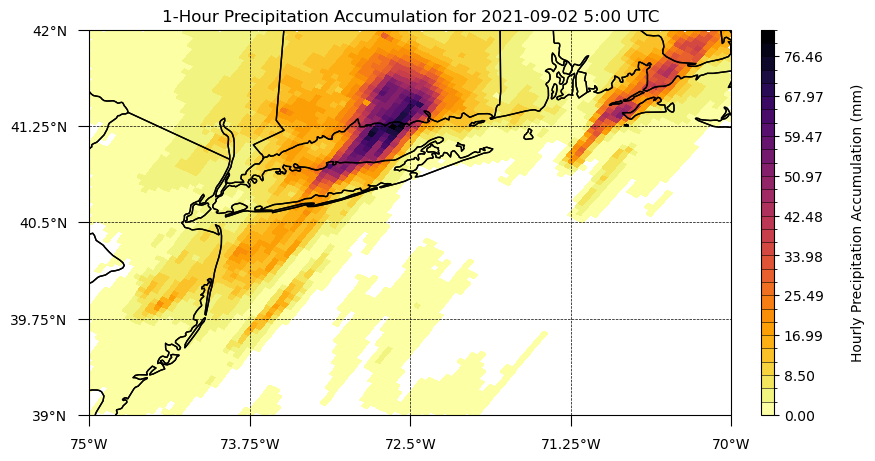

In [10]:
#Define plot CRS
plot_crs = ccrs.PlateCarree()
data_crs = ccrs.PlateCarree()

#Define lat/lon extend, ticks, and number of ticks we want on the map
lon_lat_extent   = [left_lon, right_lon, lower_lat, upper_lat]
lon_lat_ticks    = [left_lon, right_lon, lower_lat, upper_lat]
lon_lat_tick_num = [5, 5]

#Define a random time index integer for plotting a "quick look"
time_index = 20

#Define plotting variable
plotting_variable = da_hourly_precip_space_and_time_indexed.isel(time=time_index)

#Define cartopy axis
fig, ax = plt.subplots(subplot_kw={'projection': plot_crs}, figsize=(10,5))

#Add map features
ax.add_feature(cfeature.NaturalEarthFeature(category='physical', name='coastline', scale='10m', facecolor='None', zorder=10))
ax.add_feature(cfeature.NaturalEarthFeature(category='physical', name='minor_islands', scale='10m', facecolor='None', zorder=10))
ax.add_feature(cfeature.NaturalEarthFeature(category='cultural', name='admin_1_states_provinces', scale='10m', facecolor='None', zorder=10))

#Set extent of map
ax.set_extent((lon_lat_extent[0], lon_lat_extent[1] , lon_lat_extent[2], lon_lat_extent[3]), crs=plot_crs)

#Define longitude and latitude ticks using "linspace"
map_xticks = np.linspace(lon_lat_ticks[0], lon_lat_ticks[1], num=lon_lat_tick_num[0], endpoint=True).round(decimals=2) 
map_yticks = np.linspace(lon_lat_ticks[2], lon_lat_ticks[3], num=lon_lat_tick_num[1], endpoint=True).round(decimals=2)

#Setting tick locations for lon/lat (degrees; projection = plot_crs)
ax.set_xticks(map_xticks, crs=plot_crs)
ax.set_yticks(map_yticks, crs=plot_crs)

#Setting tick locations and labels for lon/lat (degrees; projection = plot_crs)
ax.set_xticks(map_xticks, crs=plot_crs)
ax.set_yticks(map_yticks, crs=plot_crs)
ax.set_xticklabels(map_xticks)
ax.set_yticklabels(map_yticks)

#Add formatter to lon/lat ticks (degree symbol & direction label)
ax.xaxis.set_major_formatter(LONGITUDE_FORMATTER)
ax.yaxis.set_major_formatter(LATITUDE_FORMATTER)

#Turn on grid and set tick paramters for grid
ax.grid(True)
ax.tick_params(axis='both', which='major', pad=8, length=8, grid_linewidth=0.5, grid_linestyle='--', grid_color='black')

#Set title for this "quick look" plot
ax.set_title(f'1-Hour Precipitation Accumulation for {str(plotting_variable.time.values)[0:10]} {str(plotting_variable.time.values)[12:16]} UTC')

#Define colorbar levels, colorbar colormap, and colorbar norms for plotting
level_min  = plotting_variable.min()
level_max  = plotting_variable.max()
levels     = np.linspace(level_min, level_max, 30)
cmap       = plt.get_cmap('inferno_r').copy()
norm       = mplc.BoundaryNorm(levels, ncolors=cmap.N, clip=False)

#Plot pcolormesh. Note that in order to not plot precipitation values equal to zero, we mask values below some arbitrarily low threshold.
pcolormesh = ax.pcolormesh(plotting_variable.lon, plotting_variable.lat, np.ma.masked_less(plotting_variable.transpose(), 0.01),
                           cmap=cmap, norm=norm, shading='nearest', alpha=1, transform=data_crs)
#Create colorbar for values
divider = make_axes_locatable(ax)
cax     = divider.append_axes("right", size="2%", pad=0.3, axes_class=plt.Axes)
cbar    = plt.colorbar(pcolormesh, cax=cax, orientation='vertical', spacing='uniform', ticks=list(levels[::3]), drawedges=True)
cbar.set_label('Hourly Precipitation Accumulation (mm)', color='black', labelpad=20)

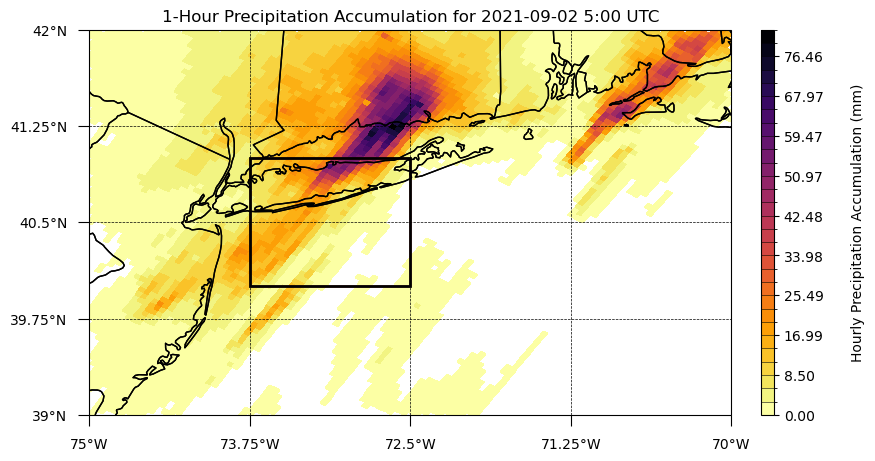

In [13]:
left_lon_box  = -73.75
right_lon_box = -72.50
upper_lat_box = 41.00
lower_lat_box = 40.00

#Add rectangle around zoomed region
#https://scitools.org.uk/cartopy/docs/v0.5/matplotlib/introductory_examples/02.polygon.html
ax.add_patch(mpatches.Rectangle(xy=[left_lon_box, lower_lat_box], 
                                width=abs((left_lon_box - right_lon_box)), 
                                height=abs((lower_lat_box-upper_lat_box)), 
                                edgecolor='black', linewidth=2, fill=False, alpha=1, zorder=4, transform=plot_crs))

fig

### Subsection to the second section

#### a quick demonstration

##### of further and further

###### header levels

as well $m = a * t / h$ text! Similarly, you have access to other $\LaTeX$ equation [**functionality**](https://jupyter-notebook.readthedocs.io/en/stable/examples/Notebook/Typesetting%20Equations.html) via MathJax (demo below from link),

\begin{align}
\dot{x} & = \sigma(y-x) \\
\dot{y} & = \rho x - y - xz \\
\dot{z} & = -\beta z + xy
\end{align}

Check out [**any number of helpful Markdown resources**](https://www.markdownguide.org/basic-syntax/) for further customizing your notebooks and the [**Jupyter docs**](https://jupyter-notebook.readthedocs.io/en/stable/examples/Notebook/Working%20With%20Markdown%20Cells.html) for Jupyter-specific formatting information. Don't hesitate to ask questions if you have problems getting it to look *just right*.

## Last Section

If you're comfortable, and as we briefly used for our embedded logo up top, you can embed raw html into Jupyter Markdown cells (edit to see):

<div class="admonition alert alert-info">
    <p class="admonition-title" style="font-weight:bold">Info</p>
    Your relevant information here!
</div>

Feel free to copy this around and edit or play around with yourself. Some other `admonitions` you can put in:

<div class="admonition alert alert-success">
    <p class="admonition-title" style="font-weight:bold">Success</p>
    We got this done after all!
</div>

<div class="admonition alert alert-warning">
    <p class="admonition-title" style="font-weight:bold">Warning</p>
    Be careful!
</div>

<div class="admonition alert alert-danger">
    <p class="admonition-title" style="font-weight:bold">Danger</p>
    Scary stuff be here.
</div>

We also suggest checking out Jupyter Book's [brief demonstration](https://jupyterbook.org/content/metadata.html#jupyter-cell-tags) on adding cell tags to your cells in Jupyter Notebook, Lab, or manually. Using these cell tags can allow you to [customize](https://jupyterbook.org/interactive/hiding.html) how your code content is displayed and even [demonstrate errors](https://jupyterbook.org/content/execute.html#dealing-with-code-that-raises-errors) without altogether crashing our loyal army of machines!

---

## Summary
Add one final `---` marking the end of your body of content, and then conclude with a brief single paragraph summarizing at a high level the key pieces that were learned and how they tied to your objectives. Look to reiterate what the most important takeaways were.

### What's next?
Let Jupyter book tie this to the next (sequential) piece of content that people could move on to down below and in the sidebar. However, if this page uniquely enables your reader to tackle other nonsequential concepts throughout this book, or even external content, link to it here!

## Resources and references
Finally, be rigorous in your citations and references as necessary. Give credit where credit is due. Also, feel free to link to relevant external material, further reading, documentation, etc. Then you're done! Give yourself a quick review, a high five, and send us a pull request. A few final notes:
 - `Kernel > Restart Kernel and Run All Cells...` to confirm that your notebook will cleanly run from start to finish
 - `Kernel > Restart Kernel and Clear All Outputs...` before committing your notebook, our machines will do the heavy lifting
 - Take credit! Provide author contact information if you'd like; if so, consider adding information here at the bottom of your notebook
 - Give credit! Attribute appropriate authorship for referenced code, information, images, etc.
 - Only include what you're legally allowed: **no copyright infringement or plagiarism**
 
Thank you for your contribution!